# VAR model  
<div style='text-align: justify;'>
A vector autoregressive model (VAR) is a multivariate generalization of the univariate autoregressive model, which treats all the variables of the system as endogenous. The VAR setting can jointly capture the dynamics of multiple time-series. According to (Sims, Macroeconomics and Reality, 1980), this model can be used in the examination of the relationships among different economic variables.
</div>

In [12]:
# Libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.vector_ar.var_model import *
import matplotlib.pyplot as plt

In [2]:
def import_data(path):
    # The data were downloaded from investment.com
    # Load Market index logarithmic returns
    df = pd.read_csv(path)

    # Change column name
    df.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)

    # Convert string to date time
    df['Date'] = pd.to_datetime(df['Date'])

    # Remove time
    df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')

    # Set frequency to avoid errors later in the VAR model
    df['Date'] = pd.DatetimeIndex(df['Date']).to_period('B')
    #df['Date'] = pd.DatetimeIndex(df['Date'])
    # Set Datetime index
    df.set_index('Date', inplace=True)
    return df

In [3]:
# Load market index prices
path1="market_indexes.csv"
market_price = import_data(path1)
# 90% of the dataset is used to train the model
end=round(len(market_price)*0.9)
market_price=market_price.iloc[0:end,:]
log_market_price = market_price.apply(np.log, axis=0)
log_market_ret = log_market_price - log_market_price.shift(1)
log_market_ret.dropna(inplace=True)

<div style='text-align: justify;'>  
The existing literature demonstrates that the results of the VAR model, especially the variance decomposition and the IRF, are affected by the ordering of the variables. The problem becomes important when the residuals exhibit serial correlation. The most appropriate way to order the variables is by exploiting the theoretical interconnections between the variables. The market indices that have a direct effect on the other indices should be placed first and variables that do not present immediate effect last. Furthermore, when theory is not straightforward, an efficient way to overcome this issue is to order the variables with respect to the Granger causality test results.
</div>

In [4]:
from statsmodels.tsa.stattools import grangercausalitytests
def grangers_causality_matrix(data, variables, lag_order=3, test = 'ssr_chi2test', verbose=False):
    # Code:
    # https://towardsdatascience.com/granger-causality-and-vector-auto-regressive-model-for-time-series-forecasting-3226a64889a6
    # https://phdinds-aim.github.io/time_series_handbook/04_GrangerCausality/04_GrangerCausality.html
    dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in dataset.columns:
        for r in dataset.index:
            test_result = grangercausalitytests(data[[r,c]], maxlag=lag_order, verbose=False)

            """x: array_like
            The data for testing whether the time series in the second column Granger
            causes the time series in the first column."""

            p_values = [round(test_result[i+1][0][test][1],4) for i in range(lag_order)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')

            min_p_value = np.min(p_values)
            # H0: X Fails to Granger-Cause Y
            # H1: X Granger-Cause Y
            if min_p_value <= 0.05:
                dataset.loc[r,c] = "YES"
            else:
                dataset.loc[r, c] = "NO"
    for i in range(len(dataset)):
        dataset.iloc[i, i] = '-'
    dataset.columns = [var + '_X' for var in variables]
    dataset.index = [var + '_Y' for var in variables]
    return dataset

In [5]:
# The Granger-Causality test is run for a lag order of five
pairwise_causality = grangers_causality_matrix(log_market_ret, variables = log_market_ret.columns, lag_order=5)
pairwise_causality.head(6)

,Brazil_X,China_X,Germany_X,Greece_X,India_X,US_X
Brazil_Y,-,NO,YES,YES,YES,YES
China_Y,YES,-,YES,YES,YES,YES
Germany_Y,NO,YES,-,YES,YES,YES
Greece_Y,YES,YES,NO,-,YES,YES
India_Y,YES,NO,YES,YES,-,YES
US_Y,YES,NO,YES,YES,YES,-


<div style='text-align: justify;'>  
The theoritical relationship between the market indices showed that the developed markets should be placed first and the emerging last. Then the variables are ordered according to the pairwise causality. All in all, the ordering of the variables is the US, Germany, India, Greece, Brazil, and China.
</div>

In [6]:
# Set the variables ordering according to  theory and pairwise causality
# Dominance and Granger
ordering=[5, 2, 4, 3, 0, 1]
log_market_ret = log_market_ret.iloc[:,ordering].copy()
market_price = market_price.iloc[:,ordering].copy()
market_indices_columns = log_market_ret.columns.values

<div style='text-align: justify;'>  
Once the variables are stationary and not-cointegrated the order of the VAR model should be decided. The number of lags (p) can be defined using an information criterion, which in this study will be the Akaike information criterion (AIC).
</div>  

### Akaike information criterion (AIC)
The formula of the AIC is: 

$$AIC = 2k - 2log(L)$$

<div style='text-align: justify;'>  
Where log(L) is the log-likelihood and k is the number of parameters of the model. This criterion is useful because it takes into account the goodness of fit and the optimal number of parameters that the model should have, denoted as the complexity of the model. The model that manages to minimize the AIC will be selected.
</div>  

### VAR(p) model specification  

$$y_{t} = A_{0} + \sum \limits_{j=1} ^{p} A_{j}y_{t-j}  + e_{t}$$  

<div style='text-align: justify;'>  
Where N is the number of the stock market indices, $y_{t}$ is N x 1 vector of the stock market indices returns, $A_{0}$ is N x 1 vector of intercepts, $A_{j}$ is N x N vector of coefficients and $e_{t}$ is N x 1 vector of error terms. It is assumed that $e_{t}$ is a vector of white noises ($e_{t}$ ~ N (0, Σ)), where Σ is the variance-covariance matrix which is considered to be positive definite.
The model parameters are estimated using the Ordinary Least Square (OLS) method.
</div>


In [7]:
model = VAR(endog=log_market_ret, dates=log_market_ret.index)

VARResults = model.fit(maxlags=10, ic='aic')
print('The AIC showed that the optimal lag order of the VAR is:')
print(VARResults.k_ar)

The AIC showed that the optimal lag order of the VAR is:
3


<div style='text-align: justify;'>   
Another way to set the number of the lags in the VAR system is to implement the multivariate portmanteau test.
</div>

### Portmanteau test
<div style='text-align: justify;'>  
This test is a multivariate extension of the Ljung–Box. It intends to investigate whether the residuals of the model are white noise.
</div>

<u>Hypothesis testing:</u>  
H0: R1= R2=…= Rh=0  
H1: Ri ≠ 0, for some i=1, …...,h  

<div style='text-align: justify;'>  
When the null hypothesis fails to be rejected then the residuals are considered to be white noise and for this reason, there is no serial correlation. In contrast, the acceptance of the alternative hypothesis implies that exists a pattern or correlation in the residuals that has not been explored by the model. To overcome this issue, the researcher should change the specification of the model, or employ another model. Moreover, additional factors that can better explain the behaviour of the endogenous variables should be added to the model. Finally, this method can be employed in the lag-order selection of the VAR or VECM model.
</div>

In [8]:
# Select lag order using Portmanteau Test
max_lag_order=7
order_selection = pd.DataFrame(0, index=range(1,max_lag_order), columns=['Lag_Order','P-Value'])
for i in range(1,max_lag_order):
    #model= VAR(endog=log_market_ret, dates=log_market_ret.index)

    VARResults=model.fit(maxlags=i, ic=None)
    white_test = VARResults.test_whiteness(nlags=max_lag_order)
    order_selection.iloc[i-1,0]=i
    order_selection.iloc[i-1,1]=white_test.pvalue


# Print Lag-Order
print('To overcome the serial autocorrelation you need a lag of:')
print(order_selection[order_selection > 0.05].dropna())

To overcome the serial autocorrelation you need a lag of:
   Lag_Order   P-Value
5          5  0.180482


### Results
<div style='text-align: justify;'> 
As the existance of serial autocorrelation is crusial and it will affect the results of the VAR model, the order of the VAR model will be 5, as indicated by the Portmanteau test.
</div>

### Fit VAR model

In [15]:
# All in all, the order of the VAR model will be 5
var_order=5

VARResults=model.fit(maxlags=var_order, ic=None)

### Multivariate Granger-Causality Test
<div style='text-align: justify;'>
In order to identify interdependences and simultaneous interactions between the indices, the previous test will be extended to a multivariate setting that is based on a VAR(5) model.
</div>

In [10]:
mult_causality=pd.DataFrame(0, index=market_indices_columns, columns=['Result'])

for i in market_indices_columns:
    results = VARResults.test_causality(i, market_indices_columns[market_indices_columns != i], kind='f')
    p_value=results.pvalue
    if p_value <= 0.05:
        mult_causality.loc[i] = 'Granger-Caused'
    else:
        mult_causality.loc[i] = 'Failed Granger-Caused'
mult_causality.head(6)

,Result
US,Granger-Caused
Germany,Granger-Caused
India,Granger-Caused
Greece,Granger-Caused
Brazil,Granger-Caused
China,Granger-Caused


### Results
<div style='text-align: justify;'>
In every case the p-value is close to zero. As a result, the alternative hypothesis, that the market indices Granger-Cause the market index, should be accepted. This is an initial indication that VAR(5) model is possible to provide useful information in a forecasting procedure.
</div>

## Impulse Response Function (IRF)

<div style='text-align: justify;'>
(Brooks, 2008) denotes in his book, that the IRF measures the reaction of the endogenous variables of the VAR system to shocks or impulses to each of the variables. Particularly, on each variable one standard deviation is applied to the disturbing term. This method is usually implemented to analyse the short-term impact of those shocks on the endogenous variables of the VAR framework. Visual graphs for each variable can illustrate those effects and are vital for interpretational purposes.
    </div>

In [16]:
irf = VARResults.irf(20)


<function matplotlib.pyplot.show(close=None, block=None)>

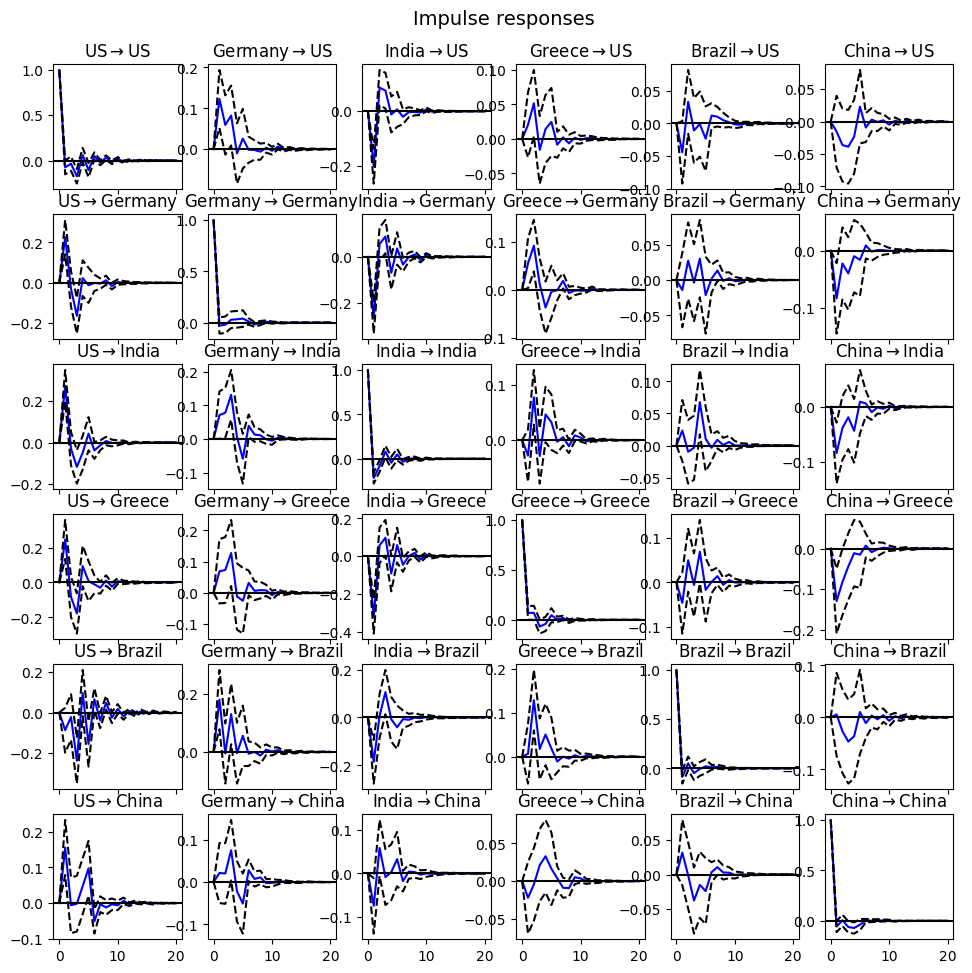

In [19]:
irf.plot()
plt.show

### Results
<div style='text-align: justify;'>
The key points of the IRF illustrate that the dominant emerging markets (India and China) have an initial negative impact on the global markets, while the developed markets have a positive one. Moreover, the most influential developing and developed market is India and the US correspondingly.
    </div>

## Forecast Error Variance Decomposition

<div style='text-align: justify;'>
The Variance decomposition method quantifies the proportion of the variance that is due to the dynamics of the endogenous variable, and the proportion that is due to the variance of the other variables of the VAR system. The idea is that an impulse in a variable will not only affect this particular variable but will also have an impact on the other variables of the system.
</div>

In [21]:
def my_fevd(model, var_p, periods=3):
    neqs = model.neqs
    names = model.endog_names

    VARResults = model.fit(maxlags=var_p, ic=None)
    irfobj = VARResults.irf(periods=periods)
    orth_irfs = irfobj.orth_irfs

    # cumulative impulse responses
    irfs = (orth_irfs[:periods] ** 2).cumsum(axis=0)

    rng = lrange(neqs)
    mse = VARResults.mse(periods)[:, rng, rng]

    # lag x equation x component
    fevd = np.empty_like(irfs)

    for i in range(periods):
        fevd[i] = (irfs[i].T / mse[i]).T

    # switch to equation x lag x component
    decomp = fevd.swapaxes(0, 1)

    return decomp

In [25]:
# Run FEDV 
decom=my_fevd(model, var_p = var_order, periods=6)

# Save the results into an Excel File
# To fix an error caused by a newer version of numpy
#decom= decom.astype(float)

#with pd.ExcelWriter(path="fevd.xlsx", engine='xlsxwriter') as writer:
#    for j in range(len(market_indices_columns)):
#        d=pd.DataFrame(data=decom[j], columns=market_indices_columns)
#        d.to_excel(writer, sheet_name=market_indices_columns[j], index=False)

#writer.close()

# References
* Brooks, C. (2008). Introductory Econometrics for Finance (2nd ed.). Cambridge University Press.  
* Sims, C. (1980). Macroeconomics and Reality. Econometrica, 48(1), 1-48. doi:https://doi.org/10.2307/1912017